# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

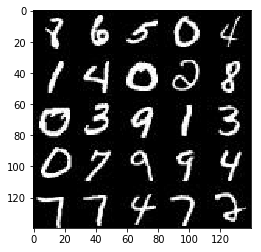

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

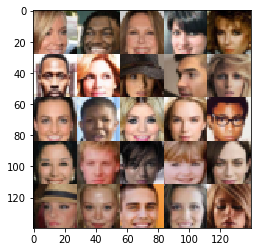

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/bmoscon/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, 
                                (None, image_width, image_height, image_channels),
                                name="real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1 * alpha, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3 * alpha, x3)

        flat = tf.reshape(x3, (-1, 4096))
        logits = tf.layers.dense(flat, 1)

        return tf.sigmoid(logits), logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        x1 = tf.layers.dense(z, 2048)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(x1 * alpha, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3 * alpha, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
    
        return tf.tanh(logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha=0.1
    
    generator_model = generator(input_z, out_channel_dim)
    discrim_model_real, discrim_logits_real = discriminator(input_real)
    discrim_model_fake, discrim_logits_fake = discriminator(generator_model, reuse=True)
    
    discrim_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_real,
                                                                               labels=tf.ones_like(discrim_model_real)))
    discrim_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_fake,
                                                                               labels=tf.zeros_like(discrim_model_fake)))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_fake,
                                                                            labels=tf.ones_like(discrim_model_fake)))

    return discrim_loss_real + discrim_loss_fake, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    generator_vars = [v for v in trainable_vars if v.name.startswith('generator')]
    discrim_vars = [v for v in trainable_vars if v.name.startswith('discriminator')]
    
    def op(loss, var):
        return tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss, var_list=var)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        return op(d_loss, discrim_vars), op(g_loss, generator_vars)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width,
                                                   image_height,
                                                   image_channels,
                                                   z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    image_step = 100
    loss_step = 20

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_opt, feed_dict={input_real: batch_images,
                                           input_z: batch_z,
                                           learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images,
                                           input_z: batch_z,
                                           learn_rate: learning_rate})

                if steps % loss_step == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % image_step == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 2.4602... Generator Loss: 4.2311
Epoch 1/2... Discriminator Loss: 0.3445... Generator Loss: 2.0076
Epoch 1/2... Discriminator Loss: 2.9587... Generator Loss: 7.0515
Epoch 1/2... Discriminator Loss: 0.2473... Generator Loss: 4.3498


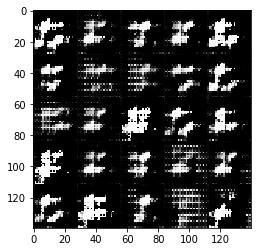

Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 2.2685... Generator Loss: 6.2578
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.8216
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 1.1845


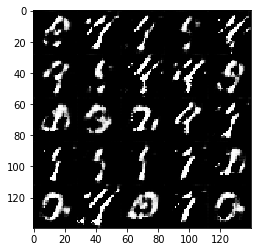

Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 4.4940
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.7060
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.3954


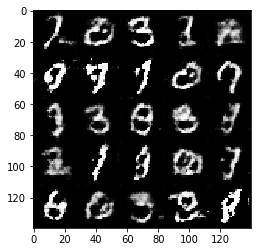

Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 2.2934
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 1.0060
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.1319


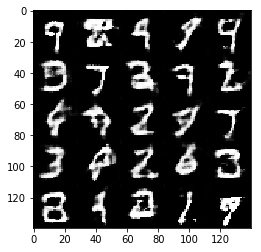

Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.4666
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.6628


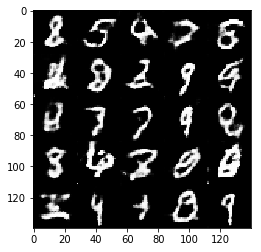

Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 1.2672
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 1.2593
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.4511


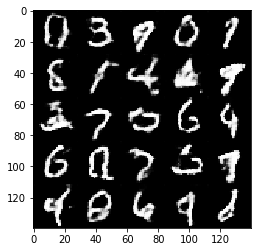

Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 2.2909
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 1.6449
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 2.1549... Generator Loss: 0.1979


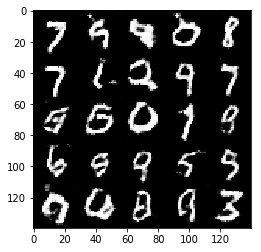

Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.0344... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 2.0819
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 0.6735


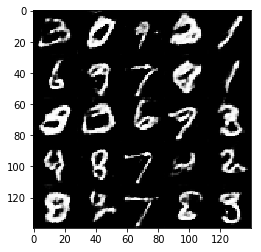

Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 2.5612
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.1672
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 1.4705
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.7850


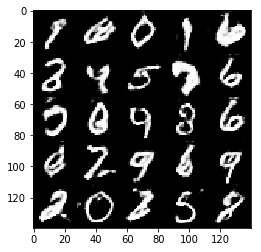

Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.9881
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.4994


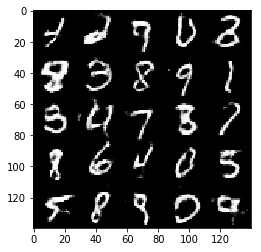

Epoch 2/2... Discriminator Loss: 1.7574... Generator Loss: 0.3406
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.4192
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.3413
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.0605


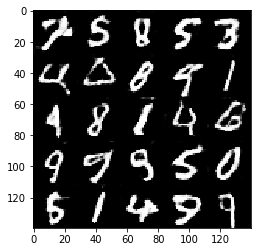

Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 0.9647... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.8239


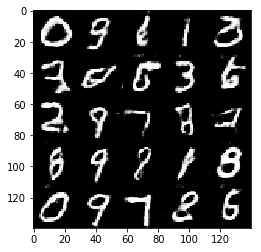

Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.5436
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 1.3651
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 2.0543... Generator Loss: 0.1870
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 1.7159


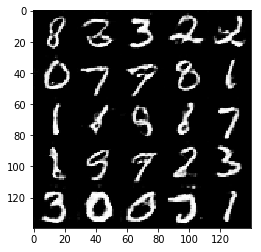

Epoch 2/2... Discriminator Loss: 1.4814... Generator Loss: 0.3926
Epoch 2/2... Discriminator Loss: 1.6766... Generator Loss: 0.3315
Epoch 2/2... Discriminator Loss: 1.8832... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.0272


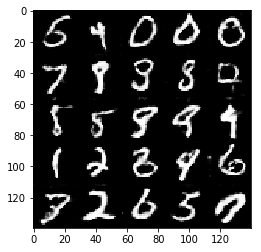

Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.8227
Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 2.0310... Generator Loss: 0.2203
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 2.3675


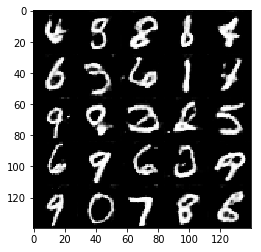

Epoch 2/2... Discriminator Loss: 1.4562... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 0.3658... Generator Loss: 1.8521
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 2.6459... Generator Loss: 0.1317
Epoch 2/2... Discriminator Loss: 0.2253... Generator Loss: 2.3762


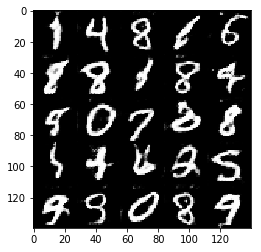

Epoch 2/2... Discriminator Loss: 2.5623... Generator Loss: 0.1415
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 1.1466
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 3.3552... Generator Loss: 0.0732
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.4748


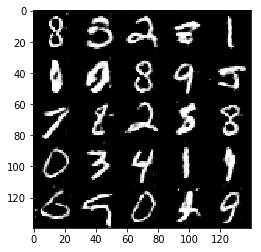

Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 2.0284
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 1.9725
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.1584
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.0751
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 0.8249


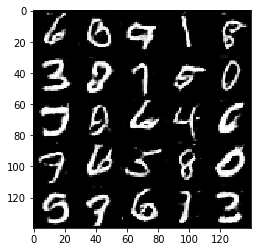

Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 2.4332... Generator Loss: 0.2000


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6776... Generator Loss: 7.8603
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 2.4646
Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 5.0120


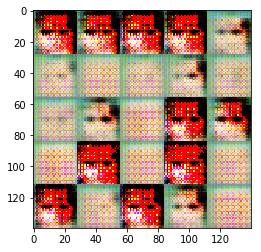

Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 3.2763
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 2.8603
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 2.0975
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.9043


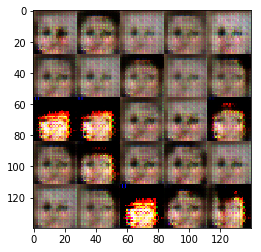

Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 2.8212
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.0428


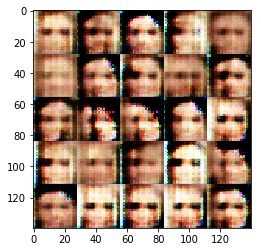

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 2.0658... Generator Loss: 2.6501
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.1516


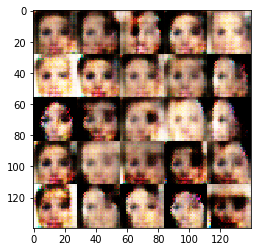

Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 2.2461
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 2.0560
Epoch 1/1... Discriminator Loss: 2.5834... Generator Loss: 2.6100


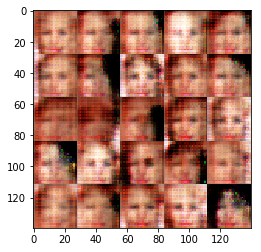

Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.3822


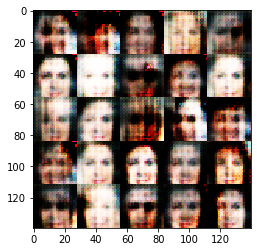

Epoch 1/1... Discriminator Loss: 1.7642... Generator Loss: 0.2868
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0969


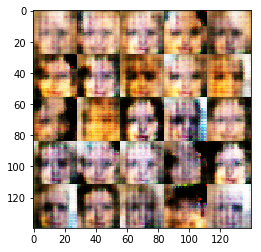

Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 2.0860... Generator Loss: 0.2372
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.3926
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.1981


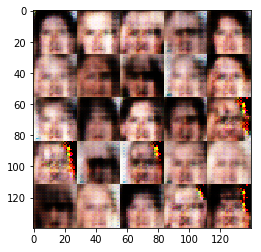

Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 2.1080
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.6976


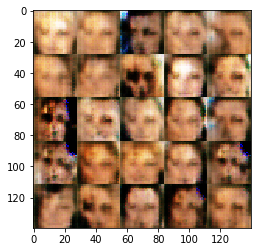

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.4006
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 2.2951
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.6944
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7348


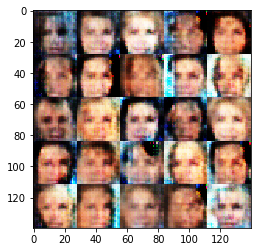

Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 2.1207... Generator Loss: 0.1939
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.2302


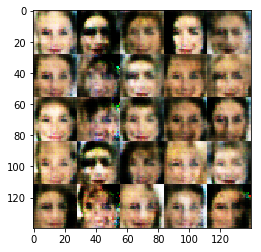

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6748


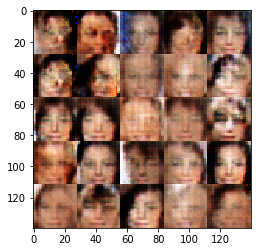

Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.7330


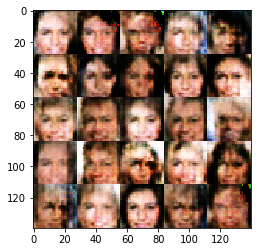

Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 0.3329
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.5472


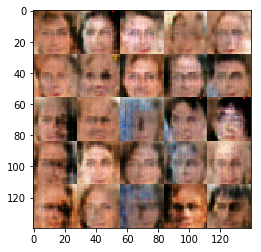

Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9588


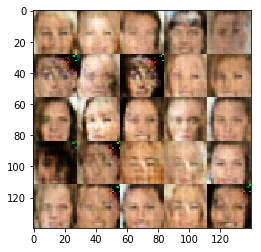

Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.2391


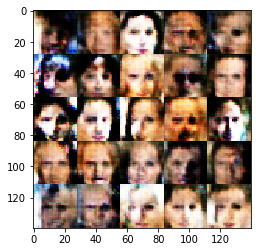

Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 2.8644
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.3120
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.1318


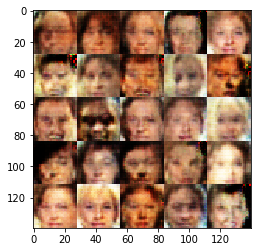

Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 2.6385
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 2.5557
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 1.8509
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.9262


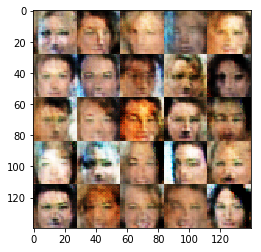

Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.2558


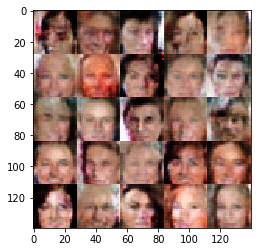

Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.2427


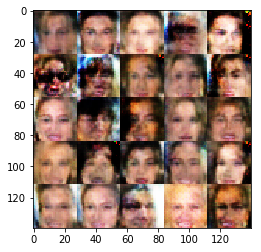

Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.8751


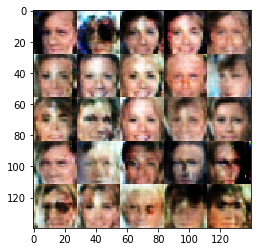

Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.4668


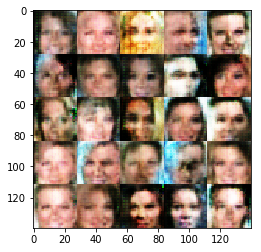

Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 2.0955... Generator Loss: 0.2186
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7753


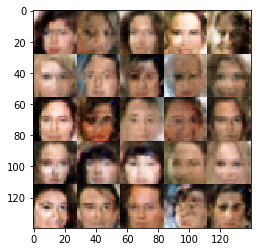

Epoch 1/1... Discriminator Loss: 2.7912... Generator Loss: 4.0229
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.5215


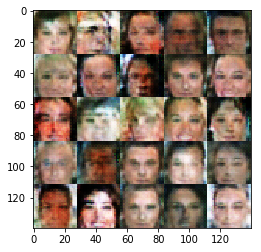

Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.6826


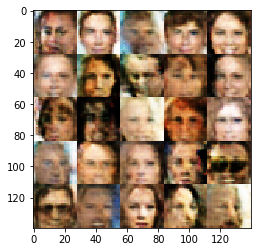

Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.8245
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.3625


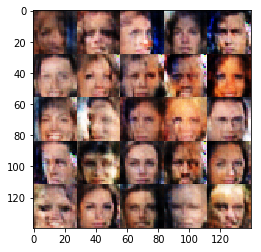

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.8352
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.7576... Generator Loss: 0.2785
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0907


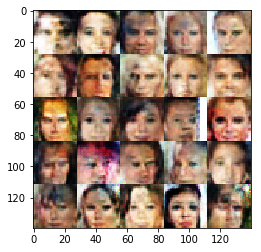

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.9454... Generator Loss: 3.6011


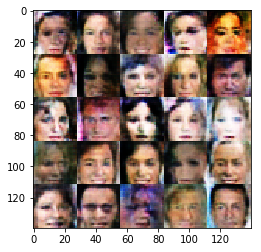

Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.4095


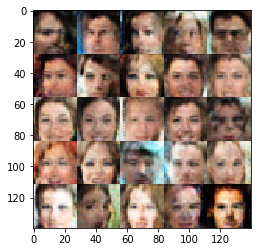

Epoch 1/1... Discriminator Loss: 1.9700... Generator Loss: 3.3311
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6289


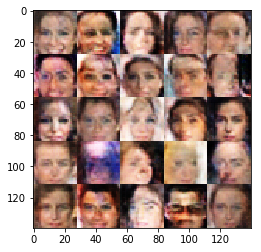

Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.6699
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.2180


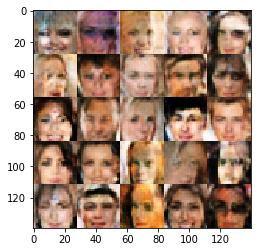

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8014


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.